### Imports

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyomo.environ import Objective, minimize

try:
    root = os.path.dirname(os.path.realpath(__file__))
except:
    root = os.getcwd()
    
# IES
sys.path.append(os.path.join(root, '..', 'derive'))
from configuration import get_simplecoupled_config
from simplecoupled import simplecoupled

# DOPER
from DOPER.wrapper import DOPER
from DOPER.utility import get_solver, get_root, standard_report
from DOPER.basemodel import base_model, convert_base_model, plot_standard1
from DOPER.batterymodel import add_battery, convert_battery, plot_battery1
from DOPER.example import example_parameter_evfleet, example_inputs

### Configuration

In [2]:
rerun_basesims = False
start_time = 0
final_time = 60*60*24*31
step_size = 5*60

### Get baseload data

In [3]:
config = get_simplecoupled_config(start_time=start_time, final_time=final_time, step_size=step_size,
                                  log_level=0, pv=True)
config['PV_scale'] = [0.2, 0.4]
if rerun_basesims:
    print('Re-simulating all buildings. This might take a while (2-4 hours).')    
    simulator = simplecoupled(config)
    basedata = simulator.simulate()
    print({k:round(v,1) for k,v in simulator.timing.items()})
    basedata[[c for c in basedata.columns if c.startswith('grid.P_load')]].to_csv('basesims.csv')
    basedata[['grid.Y_load[{}].PQ1.P'.format(x) for x in range(2, config['feeder_nodes']+1)]].to_csv('basesims.csv')
basedata = pd.read_csv('basesims.csv', index_col=[0])
basedata.index = pd.to_datetime(basedata.index)
basedata.columns = ['node[{}]'.format(x) for x in range(2, config['feeder_nodes']+1)]
basedata = basedata / -1e3 * 3 # Scale to kW; multiply*3 (3-phase)
basedata = basedata.resample('{}S'.format(step_size)).mean() # Resample to step_size

FIXME
Re-simulating all buildings. This might take a while (2-4 hours).


/usr/local/lib/python3.6/dist-packages/Assimulo-3.2.4-py3.6-linux-x86_64.egg/assimulo/solvers/odepack.py:726: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  38892959/120069679,11804845./141497517]])]
Could not find GLIMDA.


{'simulate': 6826.6, 'processing': 1.9, 'reset': 0.1}
TODO: Scale PV by 1/2 or less!


### Setup MPC

In [4]:
solver_path = get_solver('cbc', solver_dir=os.path.join(get_root(), 'solvers'))

def control_model(inputs, parameter):
    model = base_model(inputs, parameter)
    model = add_battery(model, inputs, parameter)
    
    def objective_function(model):
        return model.sum_energy_cost * parameter['objective']['weight_energy'] \
               + model.sum_demand_cost * parameter['objective']['weight_demand'] \
               + model.sum_export_revenue * parameter['objective']['weight_export']
    model.objective = Objective(rule=objective_function, sense=minimize, doc='objective function')
    return model

def pyomo_to_pandas(model, parameter):
    df = convert_base_model(model, parameter)
    df = pd.concat([df, convert_battery(model, parameter)], axis=1)
    return df

def par_battery(parameter, capacity=50, power=100, count=1):
    parameter['battery'] = {}
    parameter['battery']['count'] = count # Number of batteries
    parameter['battery']['capacity'] = [capacity]*count # kWh
    parameter['battery']['power_charge'] = [power]*count # kW
    parameter['battery']['power_discharge'] = [power]*count # kW
    parameter['battery']['soc_initial'] = [0.5]*count # State of Charge initially in 1
    parameter['battery']['soc_final'] = [0.5]*count # State of Charge finally in 1
    parameter['battery']['soc_min'] = [0]*count # State of Charge minimum in 1
    parameter['battery']['soc_max'] = [1]*count # State of Charge maximum in 1
    parameter['battery']['efficiency_charging'] = [0.96]*count # Charging efficiency [0-1]; Tesla: 0.96
    parameter['battery']['efficiency_discharging'] = [0.96]*count # Discharging efficiency [0-1]; Tesla: 0.96
    parameter['battery']['self_discharging'] = [0.0]*count # % of SoC per 24 hours
    return parameter

def par_tariff_e19_summer(parameter):
    print('FIXME')
    parameter['tariff'] = {}
    parameter['tariff']['energy'] = {0:0.08671, 1:0.11613, 2:0.16055} # $/kWh for periods 0-offpeak, 1-midpeak, 2-onpeak
    parameter['tariff']['demand'] = {0:0, 1:5.40, 2:19.65} # $/kW for periods 0-offpeak, 1-midpeak, 2-onpeak
    parameter['tariff']['demand_coincident'] = 17.74 # $/kW for coincident
    parameter['tariff']['export'] = {0:0.01} # $/kWh for periods 0-offpeak, 1-midpeak, 2-onpeak
    return parameter

def parameter_local(capacity=50, power=100, count=1):
    print('FIXME')
    parameter = example_parameter_evfleet()
    parameter = par_tariff_e19_summer(parameter)
    parameter = par_battery(parameter, capacity=capacity, power=power, count=count)
    
    # objective
    parameter['objective']['weight_energy'] = 1
    parameter['objective']['weight_demand'] = 1
    parameter['objective']['weight_export'] = 1
    return parameter

FIXME: Add GHG emissions?


In [5]:
parameter = parameter_local(capacity=50, power=100, count=1)
data = example_inputs(parameter, load='B90', scale_load=150, scale_pv=100)

smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_path=solver_path,
                 pyomo_to_pandas=pyomo_to_pandas)

res = smartDER.do_optimization(data)

# Get results
duration, objective, df, model, result, termination, parameter = res
print(standard_report(res))

FIXME
FIXME
Solver			CBC
Duration [s]		0.95
Objective [$]		4772.17			4772.17 (Total Cost)
Cost [$]		222.95 (Energy)	4549.22 (Demand)
Revenue [$]		0.0 (Export)		0.0 (Regulation)



### Compute local MPC control

In [6]:
mpc_local = pd.DataFrame()
res_local = pd.DataFrame()
res_local.loc['head', 'cost'] = 0

for node in basedata.columns:
    # run MPC
    
    # get battery dispatch
    mpc_local[node] = 0
    
    # get objective
    res_local.loc[node, 'cost'] = 0
    
# compute head objective
res_local.loc['head', 'cost'] = 0

### Compute global MPC control

In [7]:
mpc_global = pd.DataFrame()
res_global = pd.DataFrame()

# run MPC

# get head objective
res_global.loc['head', 'cost'] = 0
for node in basedata.columns:
    
    # get battery dispatch
    mpc_global[node] = 0
    
    # get objective
    res_global.loc[node, 'cost'] = 0

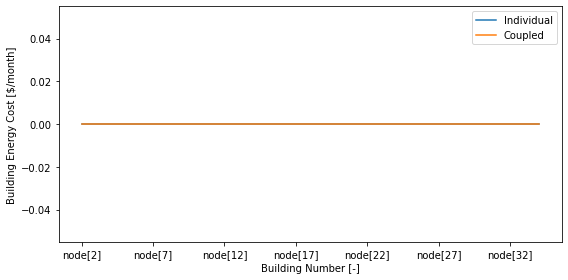

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
res_local.iloc[1:].plot(ax=ax)
res_global.iloc[1:].plot(ax=ax)
ax.set_ylabel('Building Energy Cost [$/month]')
ax.set_xlabel('Building Number [-]')
ax.legend(['Individual', 'Coupled'])
#ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()])
plt.tight_layout()
plt.show()

In [9]:
print('Global objective with local control:\t', res_local.loc['head', 'cost'])
print('Global objective with global control:\t', res_global.loc['head', 'cost'])

Global objective with local control:	 0.0
Global objective with global control:	 0.0


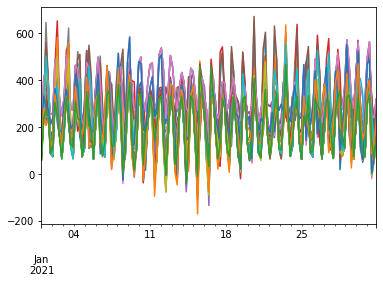

In [11]:
basedata.iloc[:5000].plot(legend=False)
plt.show()